In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:

import matplotlib.pyplot as plt
import seaborn as sns
# # Hungary
# df = pd.read_csv('../input/heart-attack-prediction/data.csv')
# df.info()

# # Full
# df = pd.read_csv('../input/heart-disease-dataset/heart.csv')
# df.info()

# Cleavland
df  = pd.read_csv("../input/heart-disease-uci/heart.csv")
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


# Data Exploration

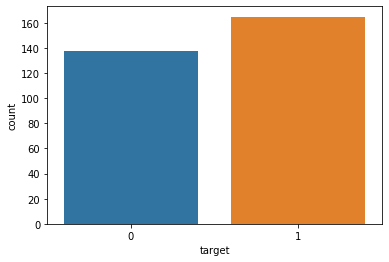

In [3]:
sns.countplot(x='target',data=df)
plt.show()

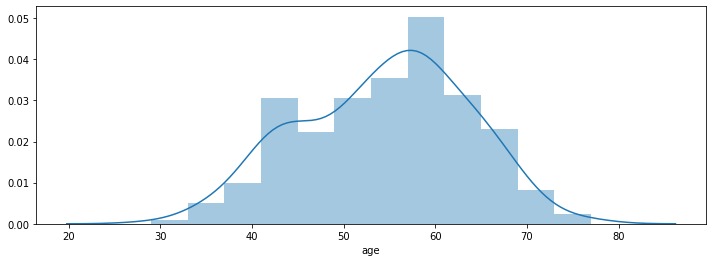

In [4]:
plt.figure(figsize=(12,4))
sns.distplot(df['age'])

(0, 14)

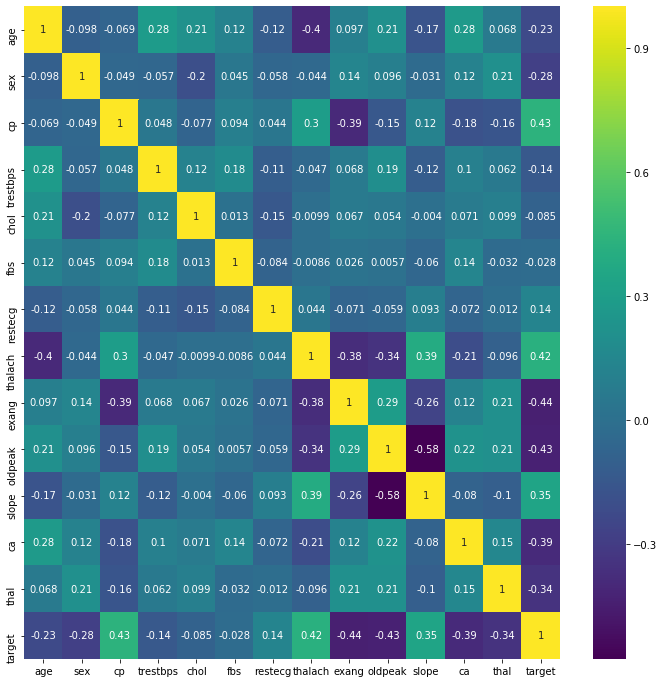

In [5]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(),annot=True,cmap='viridis')
plt.ylim(14, 0)
plt.xlim(0, 14)

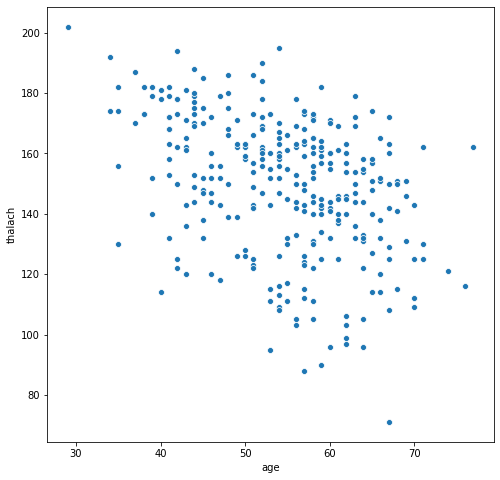

In [6]:
plt.figure(figsize=(8,8))
sns.scatterplot(x='age',y='thalach',data=df)

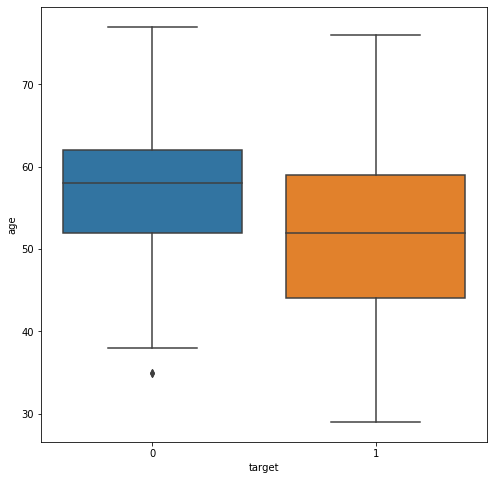

In [7]:
plt.figure(figsize=(8,8))
sns.boxplot(x='target',y='age',data=df)

In [8]:
df.groupby('target')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,138.0,56.601449,7.962082,35.0,52.0,58.0,62.0,77.0
1,165.0,52.496970,9.550651,29.0,44.0,52.0,59.0,76.0


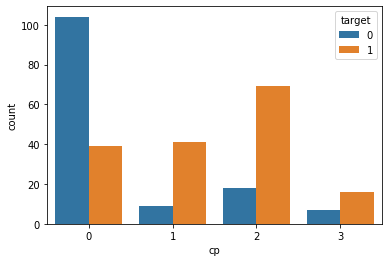

In [9]:
sorted(df['cp'].unique())
sns.countplot(x='cp',data=df,hue='target')

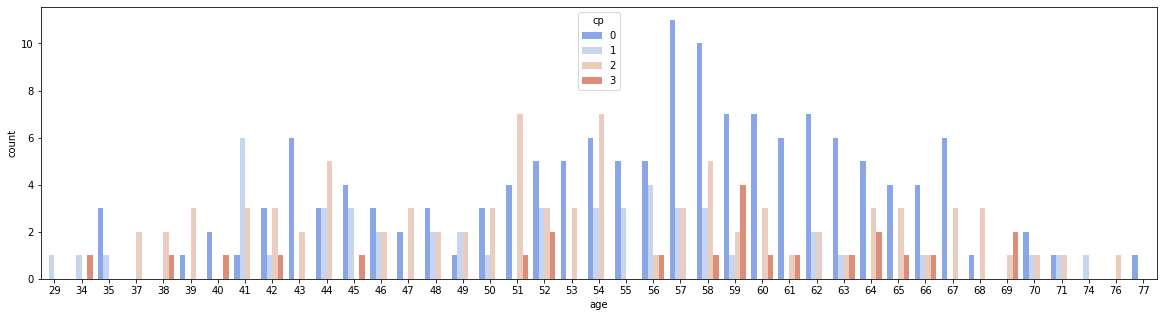

In [10]:
plt.figure(figsize=(20,5))
cp_order = sorted(df['age'].unique())
sns.countplot(x='age',data=df,order = cp_order,palette='coolwarm' ,hue='cp')

In [11]:
plt.figure(figsize=(20,5))
df.corr()['age'].sort_values().drop('age')

thalach    -0.398522
target     -0.225439
slope      -0.168814
restecg    -0.116211
sex        -0.098447
cp         -0.068653
thal        0.068001
exang       0.096801
fbs         0.121308
oldpeak     0.210013
chol        0.213678
ca          0.276326
trestbps    0.279351
Name: age, dtype: float64

<Figure size 1440x360 with 0 Axes>

In [12]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [13]:
len(df)

303

In [14]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [15]:
age_1 = df[df['target']==1].groupby("age").count()['target']
age_0 = df[df['target']==0].groupby("age").count()['target']


In [16]:
 (age_1/(age_1 + age_0))

age
29         NaN
34         NaN
35    0.500000
37         NaN
38    0.666667
39    0.750000
40    0.333333
41    0.900000
42    0.875000
43    0.625000
44    0.727273
45    0.750000
46    0.571429
47    0.600000
48    0.571429
49    0.600000
50    0.571429
51    0.750000
52    0.692308
53    0.750000
54    0.625000
55    0.375000
56    0.454545
57    0.411765
58    0.368421
59    0.357143
60    0.272727
61    0.125000
62    0.363636
63    0.333333
64    0.600000
65    0.500000
66    0.571429
67    0.333333
68    0.500000
69    0.666667
70    0.250000
71         NaN
74         NaN
76         NaN
77         NaN
Name: target, dtype: float64

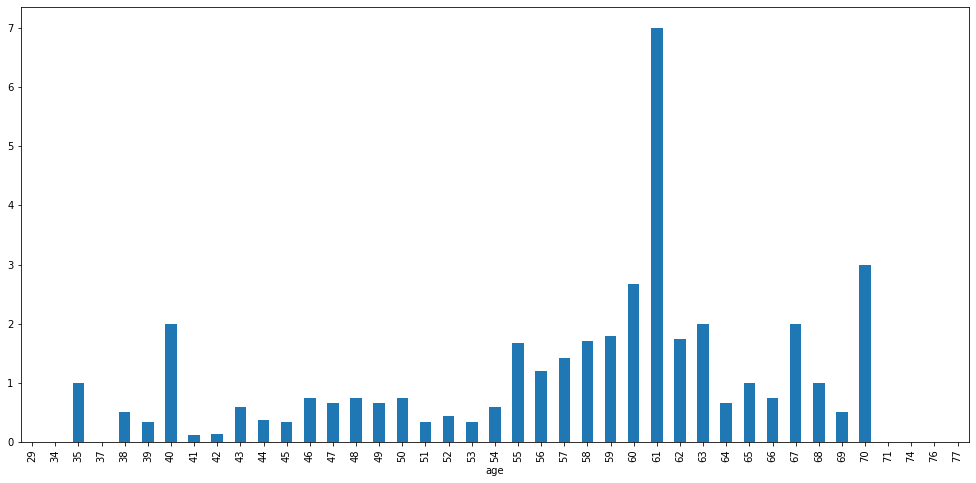

In [17]:
plt.figure(figsize=(17,8))
age_len = age_0/age_1
age_len.plot(kind = 'bar')

## Split Data

In [18]:
from sklearn.model_selection import train_test_split
df=df.sample(frac=1)

In [19]:

X = df.drop('target', axis =1).values
X

array([[58.,  0.,  2., ...,  2.,  0.,  2.],
       [38.,  1.,  2., ...,  2.,  4.,  2.],
       [54.,  1.,  0., ...,  1.,  1.,  2.],
       ...,
       [71.,  0.,  0., ...,  1.,  0.,  2.],
       [44.,  1.,  0., ...,  2.,  1.,  2.],
       [63.,  1.,  0., ...,  1.,  1.,  3.]])

In [20]:
y = df['target'].values
y

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

time = datetime.now().strftime("%Y-%m-%d--%H%M")
logdir = 'logs\\hparam_tuning'
# board = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images = True, 
#                     update_freq='epoch', profile_batch=2, embeddings_freq=1)

In [24]:
from tensorboard.plugins.hparams import api as hp
HP_NUM_UNITS_L1 = hp.HParam('num_units_l1', hp.Discrete([16, 32]))
HP_NUM_UNITS_L2 = hp.HParam('num_units_l2', hp.Discrete([8,4]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs\\hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS_L1,HP_NUM_UNITS_L2, HP_DROPOUT, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

def train_test_model(hparams):
    model = Sequential()
    # input layer
    model.add(Dense(hparams[HP_NUM_UNITS_L1],  activation='relu'))
    model.add(Dropout(hparams[HP_DROPOUT]))

    # hidden layer
    model.add(Dense(hparams[HP_NUM_UNITS_L2], activation='relu'))
    model.add(Dropout(hparams[HP_DROPOUT]))
    
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(hparams[HP_DROPOUT]))
    # output layer
    model.add(Dense(units=1,activation='sigmoid'))

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=hparams[HP_OPTIMIZER],  metrics=['accuracy'])
    
    model.fit(x=X_train, 
          y=y_train, 
          epochs=400,
          validation_data=(X_test, y_test), 
          verbose=1,
          callbacks = [early_stop,
                       tf.keras.callbacks.TensorBoard(logdir),  # log metrics
                        hp.KerasCallback(logdir, hparams)]
          )
    
    _, accuracy = model.evaluate(X_test, y_test)
    
    return accuracy

def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

session_num = 0

for num_units_l1 in HP_NUM_UNITS_L1.domain.values:
    for num_units_l2 in HP_NUM_UNITS_L2.domain.values:
        for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
            for optimizer in HP_OPTIMIZER.domain.values:
              hparams = {
                  HP_NUM_UNITS_L1: num_units_l1,
                  HP_NUM_UNITS_L2: num_units_l2,
                  HP_DROPOUT: dropout_rate,
                  HP_OPTIMIZER: optimizer,
              }
              run_name = "run-%d" % session_num
              print('--- Starting trial: %s' % run_name)
              print({h.name: hparams[h] for h in hparams})
              run('logs\\hparam_tuning' + run_name, hparams)
              session_num += 1

--- Starting trial: run-0
{'num_units_l1': 16, 'num_units_l2': 4, 'dropout': 0.1, 'optimizer': 'adam'}
Train on 242 samples, validate on 61 samples
Epoch 1/400
242/242 [==============================] - 7s 29ms/sample - loss: 0.6948 - accuracy: 0.5950 - val_loss: 0.6840 - val_accuracy: 0.4754
Epoch 2/400
242/242 [==============================] - 0s 885us/sample - loss: 0.6889 - accuracy: 0.5496 - val_loss: 0.6798 - val_accuracy: 0.4754
Epoch 3/400
242/242 [==============================] - 0s 911us/sample - loss: 0.6824 - accuracy: 0.5537 - val_loss: 0.6776 - val_accuracy: 0.4754
Epoch 4/400
242/242 [==============================] - 0s 709us/sample - loss: 0.6761 - accuracy: 0.5537 - val_loss: 0.6746 - val_accuracy: 0.4754
Epoch 5/400
242/242 [=====================

In [25]:
from sklearn.metrics import classification_report,confusion_matrix

In [26]:
predictions = model.predict_classes(X_test)
print(classification_report(y_test,predictions))

NameError: name 'model' is not defined

In [ ]:
confusion_matrix(y_test,predictions)

In [ ]:
row = 300
patient = df.drop('target', axis = 1).iloc[row]
patient['age'] = 20
patient['cp']=0.0
patient

In [ ]:
patient = scaler.transform(patient.values.reshape(1,13))
patient

In [ ]:
model.predict_classes(patient)[0]

In [ ]:
df.iloc[row]['target']

In [ ]:
result = []
for row in range (0,300):
    patient = df.drop('target', axis = 1).iloc[row]
    patient = scaler.transform(patient.values.reshape(1,13))
    result = result + model.predict_classes(patient) == df.iloc[row]['target']
print(result)